In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import warnings
import matplotlib.cbook
from IPython.display import clear_output
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
df = pd.read_csv("./rawdata/archive/2009.csv")#,nrows=999999)

# df = pd.read_csv("./rawdata/decade_flights_RAW.csv")#,nrows=99999999)

In [3]:
# path = "./rawdata/archive" # use your path
  
# # all_files = glob.glob(path + "/*.csv")
# years = range(2009,2019)
# li = []
# for year in years:
#     print(year)
#     frame = pd.read_csv(f"{path}/{year}.csv", index_col=None, header=0)
#     li.append(frame)
# df = pd.concat(li, axis=0, ignore_index=True)

In [4]:
df.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,2009-01-01,XE,1204,DCA,EWR,1100,1058.0,-2.0,18.0,1116.0,1158.0,8.0,1202,1206.0,4.0,0.0,NaN,0.0,62.0,68.0,42.0,199.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-01,XE,1206,EWR,IAD,1510,1509.0,-1.0,28.0,1537.0,1620.0,4.0,1632,1624.0,-8.0,0.0,NaN,0.0,82.0,75.0,43.0,213.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-01,XE,1207,EWR,DCA,1100,1059.0,-1.0,20.0,1119.0,1155.0,6.0,1210,1201.0,-9.0,0.0,NaN,0.0,70.0,62.0,36.0,199.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-01,XE,1208,DCA,EWR,1240,1249.0,9.0,10.0,1259.0,1336.0,9.0,1357,1345.0,-12.0,0.0,NaN,0.0,77.0,56.0,37.0,199.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-01,XE,1209,IAD,EWR,1715,1705.0,-10.0,24.0,1729.0,1809.0,13.0,1900,1822.0,-38.0,0.0,NaN,0.0,105.0,77.0,40.0,213.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df["ROUTE"] = df["ORIGIN"] + " --> " + df["DEST"]
df.drop(df.columns.difference(["FL_DATE",
                               "OP_CARRIER",
                               "ORIGIN",
                               "DEST",
                               "CRS_ELAPSED_TIME",
                               "ACTUAL_ELAPSED_TIME",
                               "AIR_TIME",
                               "DISTANCE",
                               "ROUTE"]),
        1, inplace=True)

df = df.dropna(subset=['CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE'])

df = df.astype({"CRS_ELAPSED_TIME": int, "ACTUAL_ELAPSED_TIME": int,"AIR_TIME": int,"DISTANCE": int})

df = df[df.groupby('ROUTE').ROUTE.transform(len) > 1000]

In [6]:
# df.to_csv("decade_flights.csv")

In [7]:
df.head()

,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,ROUTE
0,2009-01-01,XE,DCA,EWR,62,68,42,199,DCA --> EWR
2,2009-01-01,XE,EWR,DCA,70,62,36,199,EWR --> DCA
3,2009-01-01,XE,DCA,EWR,77,56,37,199,DCA --> EWR
5,2009-01-01,XE,ATL,EWR,147,130,96,745,ATL --> EWR
6,2009-01-01,XE,CLE,ATL,117,108,91,554,CLE --> ATL


DCA --> EWR
EWR --> DCA
ATL --> EWR
CLE --> ATL


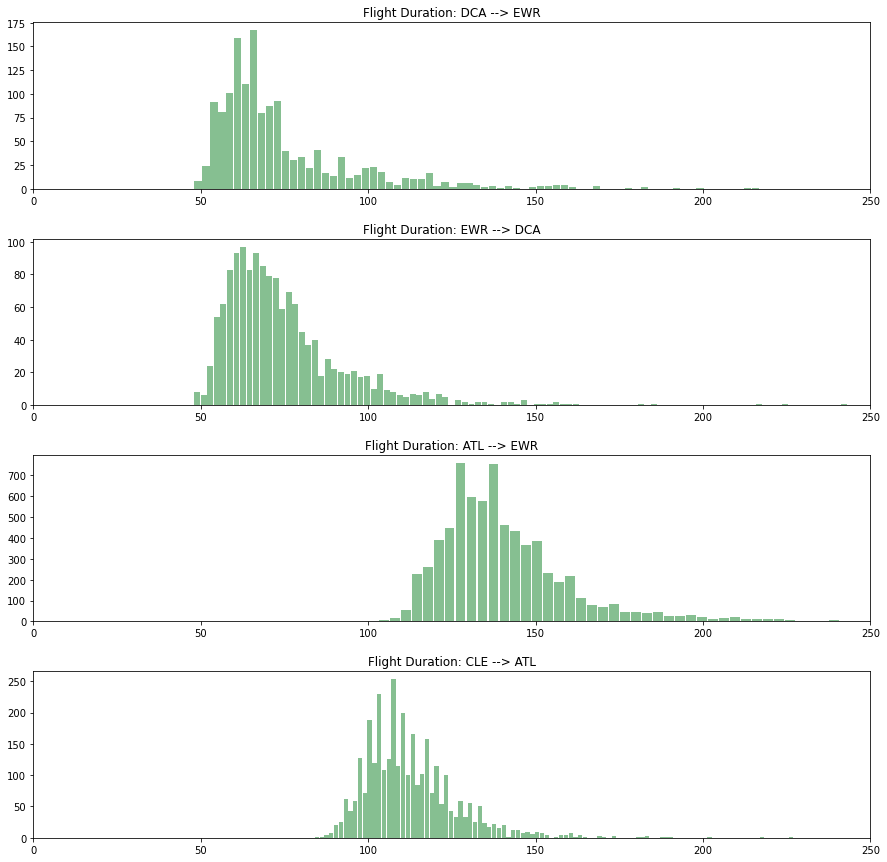

In [8]:
plot_count = 4
fig, axs = plt.subplots(plot_count,figsize=(15,15))

i = 0
for route in df.ROUTE.unique().tolist()[:plot_count]:
    print(route)
    df[df['ROUTE'] == route].hist(
        column='ACTUAL_ELAPSED_TIME', 
        bins=100,
        grid=False,
        figsize=(12,8),
        color='#86bf91',
        zorder=2,
        rwidth=0.9,
        ax=axs[i],
        sharex="row"
    )
    axs[i].title.set_text("Flight Duration: " + route)
    axs[i].set_xlim([0, 250])
    i = i + 1

In [9]:
df.ROUTE.value_counts()

OGG --> HNL    13248
HNL --> OGG    12897
SFO --> LAX    11843
LAX --> SFO    11816
LAX --> SAN    10932
               ...  
ALB --> ATL     1002
ORD --> SAV     1002
DFW --> ACT     1001
CAK --> ORD     1001
HSV --> DFW     1001
Name: ROUTE, Length: 2077, dtype: int64

In [10]:
df['ACTUAL_ELAPSED_TIME'].max()

637

In [11]:
class Probability_Distribution:
    def __init__(self, dataframe, route, field, is_null = False):
        if is_null:
            self.PDF = []
            self.CDF = []
            self.route = route
            self.field = field
            self.total_flights = 0
            self.max_field_value = 0
        else:
            PDF = [] # index refers to the field value. i.e., 10 minute flight at index 10
            CDF = [] # Cumulative version of PDF
            max_field_value = dataframe[field].max()
            route_dataframe = dataframe[dataframe['ROUTE'] == route]
            c = 0
            for i in range(max_field_value + 1):
                p = route_dataframe[route_dataframe[field] == i].shape[0]
                c = c + p
                PDF.append(p)
                CDF.append(c)
            total_flights = sum(PDF)
            PDF = [p / total_flights for p in PDF]
            CDF = [c / total_flights for c in CDF]
            self.PDF = np.array(PDF)
            self.CDF = np.array(CDF)
            self.route = route
            self.field = field
            self.total_flights = total_flights
            self.max_field_value = max_field_value

In [12]:
# class Probability_Distribution_Cluster:
#     def __init__(self,):
        

In [13]:
def EarthMoversDistance(P_Dist_A,P_Dist_B):
    return sum([abs(a_i - b_i) for a_i, b_i in zip(P_Dist_A.CDF, P_Dist_B.CDF)])

In [14]:
def GetCentroidDistribution(P_Dist_List):
    max_field_value = P_Dist_List[0].max_field_value
    field = P_Dist_List[0].field
    route = 'Centroid'
    total_flights = 0
    agg_list = np.zeros(max_field_value + 1)
    for P_Dist in P_Dist_List:
        agg_list = np.add(agg_list,P_Dist.PDF)
        total_flights = total_flights + P_Dist.total_flights
    PDF = agg_list / len(P_Dist_List)
    centroid_dist = Probability_Distribution(pd.DataFrame(), route, field, True)
    centroid_dist.PDF = PDF
    centroid_dist.CDF = np.cumsum(PDF)
    centroid_dist.route = route
    centroid_dist.field = field
    centroid_dist.total_flights = total_flights
    centroid_dist.max_field_value = max_field_value
    return centroid_dist

In [15]:
x = Probability_Distribution(df, "OGG --> HNL", "ACTUAL_ELAPSED_TIME")

In [16]:
Probability_Distribution_List = []
i = 1
last = len(df.ROUTE.unique())
for route in df.ROUTE.unique(): #[:100]:
    print(f"{i} of {last}: {route}")
    i = i + 1
    Probability_Distribution_List.append(Probability_Distribution(df, route, "ACTUAL_ELAPSED_TIME"))
    clear_output(wait=True)

2077 of 2077: HRL --> IAH


In [17]:
# for i in range(5):
#     for j in range(5):
#         EMD = EarthMoversDistance(Probability_Distribution_List[i],Probability_Distribution_List[j])
#         print(f"EMD({i},{j}) = {EMD}")



In [18]:
# Centroid_Dist = CentroidDistribution(Probability_Distribution_List)

NameError: name 'Centroid_Dist' is not defined

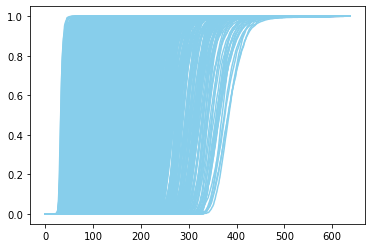

In [19]:
# for P_Dist in Probability_Distribution_List:
#     plt.plot(range(P_Dist.max_field_value + 1),P_Dist.CDF,color='skyblue')
# plt.plot(range(Centroid_Dist.max_field_value + 1),Centroid_Dist.CDF,color = 'black')
# plt.show()

In [20]:
def GetMinEMDSquared(P_Dist,ClusterCenterList):
    EMD_Squared_List = []
    for ClusterCenter in ClusterCenterList:
        EMD_Squared_List.append(EarthMoversDistance(P_Dist, ClusterCenter) ** 2)
    return min(EMD_Squared_List)

In [21]:
def GetMinEMDSquaredList(P_Dist_List,ClusterCenterList):
    Min_EMD_Squared_List = []
    for P_Dist in P_Dist_List:
        Min_EMD_Squared_List.append(GetMinEMDSquared(P_Dist,ClusterCenterList))
    return Min_EMD_Squared_List

In [22]:
def GetInitialEPMeansClusterCenters(P_Dist_List,k):
    InitialEPMeansClusterCenters = []
    init_dist = random.choice(P_Dist_List)
    P_Dist_List.remove(init_dist)
    InitialEPMeansClusterCenters.append(init_dist)
    while len(InitialEPMeansClusterCenters) < k:
        MinEMDSquaredList = GetMinEMDSquaredList(P_Dist_List,InitialEPMeansClusterCenters)
        new_cluster_center = random.choices(P_Dist_List, weights = MinEMDSquaredList)[0]
        P_Dist_List.remove(new_cluster_center)
        InitialEPMeansClusterCenters.append(new_cluster_center)
    return InitialEPMeansClusterCenters

In [23]:
def GetClusterList(P_Dist_List,ClusterCenters):
    ClusterList = []
    for ClusterCenter in ClusterCenters:
        Cluster = []
        for P_Dist in P_Dist_List:
            min_EMD = min([EarthMoversDistance(P_Dist,x) for x in ClusterCenters])
            if EarthMoversDistance(P_Dist,ClusterCenter) == min_EMD:
                Cluster.append(P_Dist)
        ClusterList.append(Cluster)
    return ClusterList

In [24]:
def EPMeans(P_Dist_List,k):
    ClusterCenters = GetInitialEPMeansClusterCenters(P_Dist_List,k)
    ClusterList = GetClusterList(P_Dist_List,ClusterCenters)
    isDone = False
    while(not isDone):
        NewClusterCenters = []
        for Cluster in ClusterList:
            NewClusterCenters.append(GetCentroidDistribution(Cluster))
        NewClusterList = GetClusterList(P_Dist_List,NewClusterCenters)
        if ClusterList == NewClusterList:
            isDone = True
        else:
            ClusterList = NewClusterList
            ClusterCenters = NewClusterCenters
    return ClusterList

In [25]:
EP = EPMeans(Probability_Distribution_List,5)

KeyboardInterrupt: 

In [ ]:
plt.rcParams["figure.figsize"] = (20,2)

# EP = EPMeans(Probability_Distribution_List,5)

for cluster in EP:
    for P_Dist in cluster:
        plt.plot(range(P_Dist.max_field_value + 1),P_Dist.CDF,color='skyblue')
    plt.plot(range(GetCentroidDistribution(cluster).max_field_value + 1),GetCentroidDistribution(cluster).CDF,color = 'black')
    plt.xlim([0, 200])
    plt.show()